# Datawhale AI 夏令营 第二期
## NLP 赛道深度学习 Baseline 代码精读
---

<p>骆秀韬 epsilon_luoo@outlook.com</p>

聪明办法学 Python 教学团队

# 导入所需工具

In [2]:
# 忽略 Paddle 警告
import warnings
warnings.filterwarnings("ignore")

import numpy as np # 数值计算
import pandas as pd # 数据分析
from tqdm import tqdm # 进度条显示
import paddle # PaddlePaddle 深度学习框架
from paddlenlp.transformers import AutoModelForSequenceClassification, AutoTokenizer # 飞桨自然语言处理工具包（模型、分词器）
from paddle.io import DataLoader # 数据加载器
from paddlenlp.datasets import MapDataset # 数据集转换
from sklearn.model_selection import train_test_split # 训练集与验证集拆分
import matplotlib.pyplot as plt # 绘图

# 导入数据集

In [3]:
data = pd.read_csv("data/train.csv") # 加载赛事提供的训练数据
test_data = pd.read_csv("data/test.csv") # 加载赛事所需提交的测试数据
data.sample(frac=1).head() # 随机查看 5 行训练数据中的内容

,name,label,content
2850,2851,1,[ 593 1296 148 242 3747 1107 4242 1759 266 ...
13636,13637,0,[5169 3125 1106 169 5212 2044 3974 3670 4889 ...
5566,5567,0,[ 0 0 0 1539 1759 266 292 1581 3125 ...
13427,13428,0,[ 998 1759 3125 3037 2575 4683 2177 4253 1105 ...
5976,5977,1,[2187 2206 2214 3938 677 3967 455 123 148 ...


In [4]:
test_data.info() # 查看测试数据信息

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   name     10000 non-null  int64 
 1   content  10000 non-null  object
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


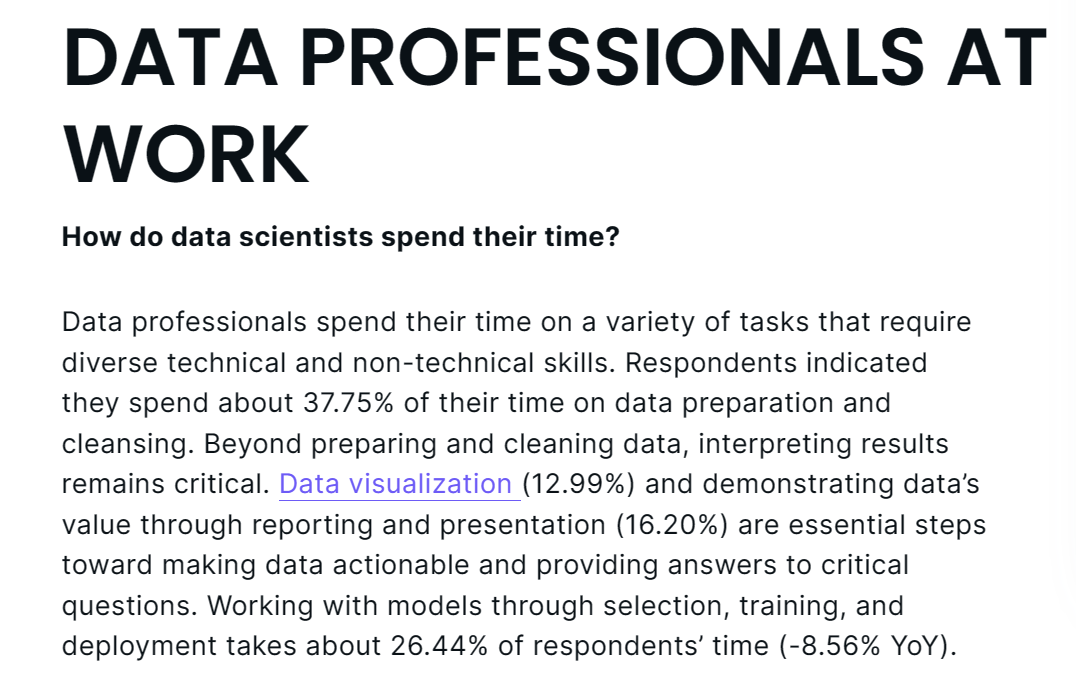

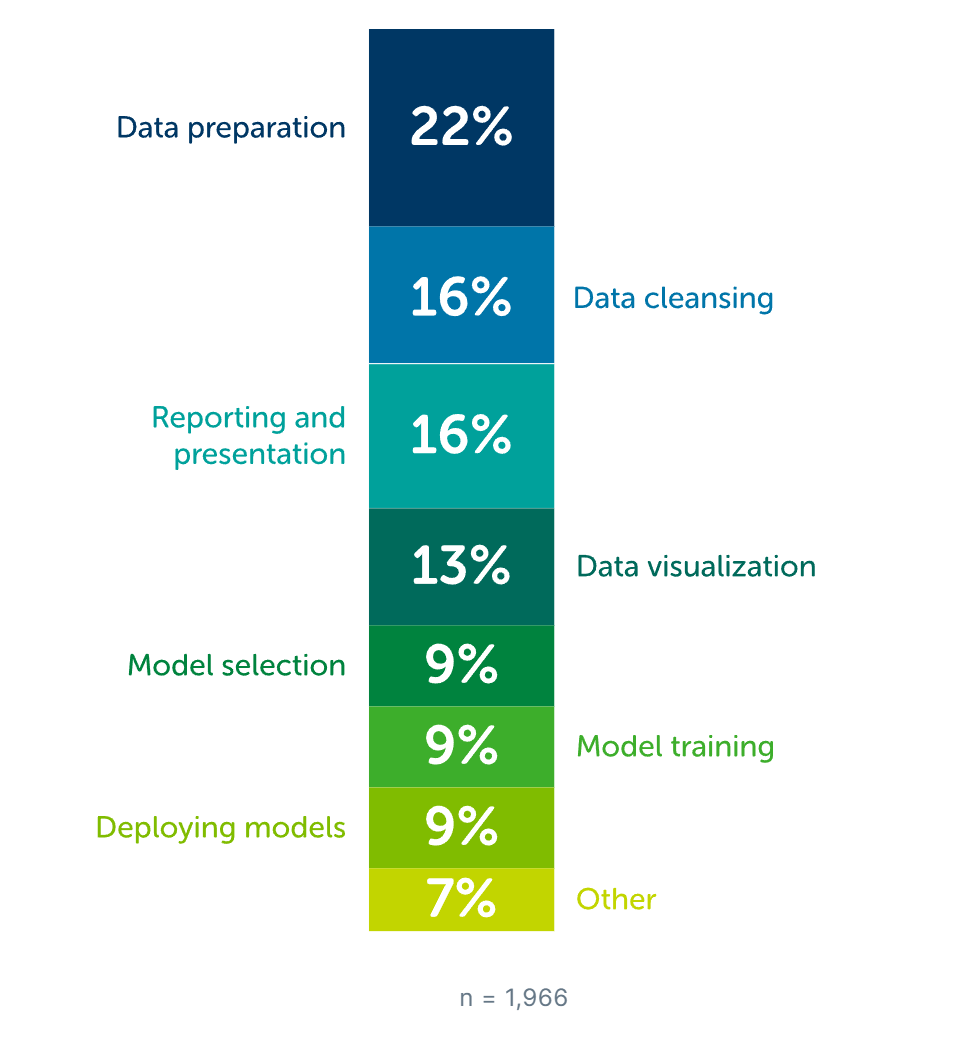

# 探索性数据分析（Exploratory Data Analysis）

In [5]:
# 计算 content 这一列的缺失率
print((data.shape[0] - data['content'].count()) / data.shape[0])

# 计算缺失 content 值的行数
print(data[data['content'].isna()].count())

0.0
name       0
label      0
content    0
dtype: int64


In [6]:
# 计算 label 这一列的缺失率
print((data.shape[0] - data['label'].count()) / data.shape[0])

# 计算缺失 label 值的行数
print(data[data['label'].isna()].count())

0.0
name       0
label      0
content    0
dtype: int64


句子长度分布图：绝大多数的句子都在 600 词以上，大部分的句子在 1000 词附近

Text(0.5, 1.0, 'Data')

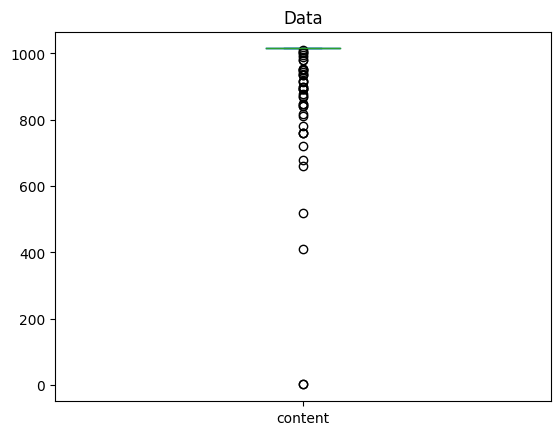

In [7]:
# 句子长度分布图
data['content'].apply(len).plot(kind='box')
plt.title('Data')

句子长度分布数据：作文长度一般是 1015 词左右

In [8]:
# 句子长度分布数据
data["content"].apply(len).describe()

count    14000.000000
mean      1014.411857
std         16.114179
min          2.000000
25%       1015.000000
50%       1015.000000
75%       1015.000000
max       1015.000000
Name: content, dtype: float64

标签分布图：不均衡，0 类远多于 1 类

Text(1, 1, 'label\n0    11836\n1     2164\nName: count, dtype: int64')

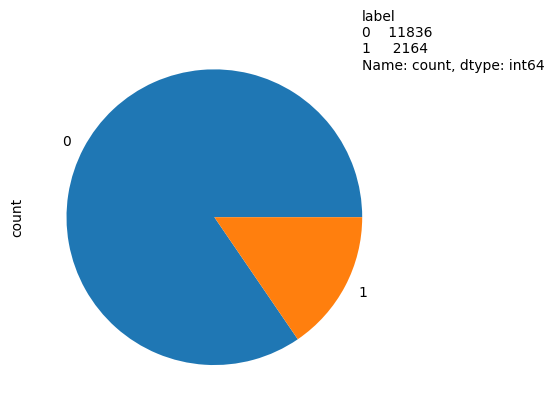

In [9]:
# 标签分布图
data["label"].value_counts().plot(kind="pie").text(1, 1, f"{data['label'].value_counts()}")

# 模型定义与训练

数据集格式转换

In [10]:
# 按照 10% 的比例划分训练集与验证集
train_data, valid_data = train_test_split(data[:10], test_size=0.1)

# 下面就是一堆操作，把数据变成数据加载器可以识别的格式，自定义数据集类也是同样的效果
train_dict = train_data.to_dict(orient='records')
valid_dict = valid_data.to_dict(orient='records')
train_ds = MapDataset(train_dict)
valid_ds = MapDataset(valid_dict)

# 将整体数据拆分为 <总样本数 / 2> 份，放入数据加载器，就是一次性会有 2 份数据同时并行计算，份数越多，并行越多，显存占用越大，需要根据需求来选择
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True) # 训练数据可以随机打乱，让模型更好地学习，减轻学习到无关特征的问题
valid_loader = DataLoader(valid_ds, batch_size=2) # 这里用的是 1650TI 4G，如果是显存更小的卡，需要调小一点，不然会炸显存

模型定义

In [12]:
# 载入模型与分词器

# 使用 ernie-3.0-mini-zh 序列分类模型，并将分类类别数设置为 2
model = AutoModelForSequenceClassification.from_pretrained("ernie-3.0-mini-zh", num_classes=2)
# 使用 ernie-3.0-mini-zh 分词器
tokenizer = AutoTokenizer.from_pretrained("ernie-3.0-mini-zh")

# 定义 AdamW 优化器，学习率为 0.000001
optimizer = paddle.optimizer.AdamW(1e-5, parameters=model.parameters())

# 定义损失函数为交叉熵函数，计算每个 mini batch 的均值
loss_fn = paddle.nn.loss.CrossEntropyLoss(reduction='mean')

[2023-08-08 20:42:41,111] [    INFO] - We are using <class 'paddlenlp.transformers.ernie.modeling.ErnieForSequenceClassification'> to load 'ernie-3.0-mini-zh'.
[2023-08-08 20:42:41,114] [    INFO] - Model config ErnieConfig {
  "attention_probs_dropout_prob": 0.1,
  "enable_recompute": false,
  "fuse": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 2048,
  "model_type": "ernie",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "paddlenlp_version": null,
  "pool_act": "tanh",
  "task_id": 0,
  "task_type_vocab_size": 16,
  "type_vocab_size": 4,
  "use_task_id": true,
  "vocab_size": 40000
}

[2023-08-08 20:42:48,121] [ WARNING] - Some weights of the model checkpoint at ernie-3.0-mini-zh were not used when initializing ErnieForSequenceClassification: ['ernie.encoder.layers.6.self_attn.k_proj.bias', 'ernie.encode

模型训练

In [14]:
for epoch in range(2): # 训练 2 轮
    # 训练过程
    model.train() # 切换模型为训练模式
    for batch_x in tqdm(train_loader): # 每次从数据加载器读入一批(batch)数据
        X = tokenizer(batch_x["content"], max_length=1015, padding=True) # 将数据转换为模块可处理的数据形式
        input_ids = paddle.to_tensor(X['input_ids'], dtype="int32") # 将 input_ids 变为张量，方便并行计算
        token_type_ids = paddle.to_tensor(X['token_type_ids'], dtype="int32") # 将 token_type_ids 变为张量
        pred = model(input_ids, token_type_ids) # 将数据读入模型，并得到计算后的结果
        loss = loss_fn(pred, paddle.to_tensor(batch_x["label"], dtype="int32")) # 对比预测结果与真实结果，计算损失函数的值
        loss.backward() # 反向传播，计算梯度
        optimizer.step() # 优化器根据梯度与学习率调整模型参数
        optimizer.clear_gradients() # 清空梯度，避免下次梯度计算时累加

    # 验证过程
    model.eval() # 切换模型为验证模式
    val_loss = [] # 验证集数据的损失函数合集
    with paddle.no_grad(): # 在模型验证时，只做前向计算，因此不需要保存梯度信息
        for batch_x in tqdm(valid_loader): # 下面的操作与训练过程相同
            X = tokenizer(batch_x["content"], max_length=1015, padding=True)
            input_ids = paddle.to_tensor(X['input_ids'], dtype="int32")
            token_type_ids = paddle.to_tensor(X['token_type_ids'], dtype="int32")
            pred = model(input_ids, token_type_ids)
            loss = loss_fn(pred, paddle.to_tensor(batch_x["label"], dtype="int32"))
            val_loss.append(loss.item()) # 将计算出的损失函数值存入合集
            
    # 打印本轮训练的验证集损失函数值，与预测正确率
    print('Epoch {0}, Val loss {1:3f}, Val Accuracy {2:3f}'.format(
    epoch,
    np.mean(val_loss), 
    (pred.argmax(1) == batch_x["label"]).astype('float').mean().item()
))
# 保存模型参数
paddle.save(model.state_dict(), "work/model.pdparams")
# 保存优化器参数
paddle.save(optimizer.state_dict(), "work/optimizer.pdopt")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 52.45it/s]


Epoch 0, Val loss 0.319446, Val Accuracy 1.000000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.42it/s]


Epoch 1, Val loss 0.265423, Val Accuracy 1.000000


# 模型载入

In [ ]:
# 如果你拿到了模型参数（在 AIStudio 中提供），你可以运行这行代码，如果直接运行模型，则没有必要运行

# 载入模型参数、优化器参数的最后一个epoch保存的检查点
layer_state_dict = paddle.load("model.pdparams")
opt_state_dict = paddle.load("optimizer.pdopt")

# 将加载后的参数与模型关联起来
model.set_state_dict(layer_state_dict)
optimizer.set_state_dict(opt_state_dict)

# 推理过程

In [17]:
# 自定义推理函数
def infer(string: str) -> int:
    """将文本传入模型并返回预测结果
    
    输入：
        - string: str
            待预测的文本内容
    
    输出:
        - result: int
            模型的预测结果
    """
    
    X = tokenizer([string], max_length=1015, padding=True)
    input_ids = paddle.to_tensor(X['input_ids'], dtype="int32")
    token_type_ids = paddle.to_tensor(X['token_type_ids'], dtype="int32")
    pred = model(input_ids, token_type_ids)
    result = pred.argmax(1).item() # 获取预测概率最大的那个类别
    return result

提交文件生成

In [18]:
test_data["label"] = test_data["content"][:100].apply(infer) # 将测试集的每个文本送入模型返回结果
submit = test_data.drop(columns=["content"]) # 生成提交数据（就是把带结果的测试集丢掉内容，复制一份）
submit.to_csv("submit.csv", index=False) # 保存 CSV 文件
test_data.head(10)

,name,content,label
0,14001,[3125 2196 286 123 1539 1759 266 3549 649 ...,0.0
1,14002,[1109 2113 3122 213 3125 1294 5212 2338 2233 ...,0.0
2,14003,[ 236 3125 139 3037 5212 4294 1600 4550 3169 ...,0.0
3,14004,[ 13 13 13 0 0 0 245 1472 3125 ...,0.0
4,14005,[2113 2444 139 1109 4648 4626 181 3635 1145 ...,0.0
5,14006,[ 664 139 220 1759 248 2188 664 4544 3125 ...,0.0
6,14007,[1472 2214 5212 1759 3125 1294 199 675 3037 ...,0.0
7,14008,[ 13 0 0 0 216 2176 3125 526 1100 ...,0.0
8,14009,[5212 1339 3747 4242 1759 266 2101 3122 1115 ...,0.0
9,14010,[3125 2278 983 4982 2138 284 3635 5212 2113 ...,0.0


# Thank You ;-)
Datawhale 聪明办法学 Python 教学团队出品

## 关注我们
Datawhale 是一个专注 AI 领域的开源组织，以“for the learner，和学习者一起成长”为愿景，构建对学习者最有价值的开源学习社区。关注我们，一起学习成长。
<div align=center><img src="datawhale_wechat_qrcode.jpeg" width = "250" height = "270"></div>